In [25]:
# !pip install wfdb

In [26]:
from pathlib import Path
from typing import Iterable, Tuple
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import wfdb
from scipy.signal import butter, filtfilt, iirnotch
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [27]:
dataset_folder_path = Path(r"C:\Users\ANA\Desktop\Finki\VNP\proekt\gesture-recognition-and-biometrics-electromyogram-grabmyo-1.1.0")
sample_rate = 2048
channels = "all"
train_sessions = {1,2}
test_sessions = {3}
num_participants = 8
gestures = set(range(1,9))
max_trials = 3
# parametri za ,,windowing" na signalite 
window_time = 0.20
hop_time_seconds = 0.05
max_windows_per_single_trial = 60

In [28]:
# func za zemanje na site header files vo daden folder
def get_all_header_records(folder: Path):
    return sorted(folder.rglob("*.hea"))
    
# func za session number, participant id, gesture id, trial id
def parse_name(file_stem: str):
    parts = file_stem.split("_") 
    session_num = int(parts[0].replace("session",""))
    participant_id = int(parts[1].replace("participant",""))
    gesture_id = int(parts[2].replace("gesture",""))
    trial_id = int(parts[3].replace("trial",""))
    return session_num, participant_id, gesture_id, trial_id
    
# func za chitanje .hea i .dat files
def read_signals(hea_path: Path):
    base_name = str(hea_path.with_suffix(""))
    return wfdb.rdsamp(base_name)

In [29]:
# preprocessing

In [30]:
def select_channels(signal, mode="all"):
    if mode == "forearm":
        idx = range(0, 16)
    elif mode == "wrist":
        idx = list(range(17, 23)) + list(range(25, 31))
    elif mode == "all":
        idx = [i for i in range(signal.shape[1]) if i not in [16, 23, 24, 31]]
    else:
        raise ValueError("forearm, wrist или all")
    return signal[:,idx]

In [31]:
# noise removing za da ne dominira vrz EMG signalot i da go maskira
def remove_50hz_noise(signal, fs):
    b, a = iirnotch(50, 30, fs)
    return filtfilt(b, a, signal, axis=0) 

In [32]:
# filter samo na signali so frequency[20,450] -> standarden chekor vo EMG istrazhuvanja
def bandpass_filter(data, low_cut=20, high_cut=450, fs=2000, order=4):
    nyq = fs / 2
    if high_cut >= nyq:
        high_cut = nyq-1
    if low_cut >= high_cut:
        low_cut = high_cut / 2
    low = low_cut / nyq
    high = high_cut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

In [33]:
def preprocess(signal, fs, mode="all"):
    processed_signal = select_channels(signal, mode)
    
    processed_signal = remove_50hz_noise(processed_signal, fs)
    
    processed_signal = bandpass_filter(processed_signal, fs=fs)
    
    processed_signal = (processed_signal - np.mean(processed_signal, axis=0)) / (
        np.std(processed_signal, axis=0) + 1e-6
    )
    return processed_signal

In [34]:
# windowing 

In [35]:
def extract_features(window):
    feats = []
    for ch in range(window.shape[1]):
        x = window[:, ch]
        mav = np.mean(np.abs(x))
        rms = np.sqrt(np.mean(x**2))
        wl = np.sum(np.abs(np.diff(x)))
        zc = np.sum(((x[:-1] * x[1:]) < 0).astype(int))
        feats.extend([mav, rms, wl, zc])
    return np.array(feats, dtype=np.float32)

def make_windows(signal, label, fs=2048, window_time=0.2, hop_time=0.05):
    win_size = int(window_time * fs)
    hop_size = int(hop_time * fs)
    X, F, Y = [], [], []
    for start in range(0, len(signal) - win_size, hop_size):
        win = signal[start:start+win_size]
        feat = extract_features(win)
        X.append(win)
        F.append(feat)
        Y.append(label)
    return X, F, Y


In [36]:
def sliding_windows(signal, fs, win_s, hop_s, max_windows=None):
    window_length = int(round(win_s*fs))
    hop_length = int(round(hop_s*fs))
    if len(signal) < window_length:
        return np.empty((0, window_length, signal.shape[1]))
    starts = list(range(0,len(signal)-window_length+1,hop_length))
    if max_windows is not None and len(starts)>max_windows:
        starts = starts[:max_windows]
    return np.stack([signal[s:s+window_length] for s in starts], axis=0)

In [37]:
def channel_features(channel, threshold):
    MAV = float(np.mean(np.abs(channel)))
    RMS = float(np.sqrt(np.mean(channel**2)))
    VAR = float(np.var(channel))
    WL = float(np.sum(np.abs(np.diff(channel))))
    ZC = int(np.sum((channel[:-1] * channel[1:]<0) & (np.abs(channel[:-1] - channel[1:])>threshold)))
    
    diff1 = np.diff(channel)
    SSC = int(np.sum((diff1[:-1] * diff1[1:]<0) & (np.abs(diff1[:-1]-diff1[1:]) > threshold)))
    wamp = int(np.sum(np.abs(np.diff(channel)) > threshold))
  
    return [MAV, RMS, VAR, WL, ZC, SSC, wamp]

In [38]:
def features_for_window(window,thresh_frac=0.05):
    num_channels = window.shape[1]
    thresholds = np.std(window, axis=0) * thresh_frac + 1e-8
    features = []
    for ch in range(num_channels):
        features.extend(channel_features(window[:,ch],thresholds[ch]))
    return np.array(features,dtype=np.float32)

In [39]:
def featurize_windows(windows):
    if len(windows) == 0:
        return np.empty((0,), dtype=np.float32)
    features = [features_for_window(w) for w in windows]
    return np.array(features, dtype=np.float32)

In [40]:
def make_dataset(root_folder: Path,
                 sessions=(1,2),
                 channel_mode="forearm",
                 gestures_to_keep=range(1,9),
                 max_participants=8,
                 max_trials_per_gesture=3,
                 window_seconds=0.2,
                 hop_seconds=0.05,
                 sample_rate_hz=2048,
                 max_windows_per_trial=60):
    
    sessions_set = set(sessions)
    gestures_set = set(gestures_to_keep)
    counts = defaultdict(int) 

    X_raw_list, X_feat_list, y_all_list = [], [], []

    all_files = get_all_header_records(root_folder)

    for fpath in tqdm(all_files, desc="Reading files"):
        sess, part, gest, trial = parse_name(fpath.stem)

        if sess not in sessions_set or gest not in gestures_set or part > max_participants:
            continue
        key = (part, gest)
        if counts[key] >= max_trials_per_gesture:
            continue
        counts[key] += 1

        signal, meta = read_signals(fpath)
        fs = int(meta.get("fs", sample_rate_hz))
        signal_filt = preprocess(signal, fs, channel_mode)

        # kreiranje prozorci
        windows = sliding_windows(signal_filt, fs, win_s=window_seconds,
                                  hop_s=hop_seconds, max_windows=max_windows_per_trial)
        if windows.shape[0] == 0:
            continue

        # raw + features
        X_win, F_win, Y_win = [], [], []
        for w in windows:
            feats = extract_features(w)
            X_win.append(w)
            F_win.append(feats)
            Y_win.append(gest - 1)

        X_raw_list.append(np.array(X_win, dtype=np.float32))
        X_feat_list.append(np.array(F_win, dtype=np.float32))
        y_all_list.append(np.array(Y_win, dtype=np.int32))

    if not X_raw_list:
        raise RuntimeError("No examples found!")
        
    X_raw = np.vstack(X_raw_list)
    X_feat = np.vstack(X_feat_list)
    y_all = np.concatenate(y_all_list)

    return X_raw, X_feat, y_all

In [41]:
X_raw_train, X_feat_train, y_train = make_dataset(
    dataset_folder_path, 
    sessions=train_sessions, 
    channel_mode=channels
)

X_raw_test, X_feat_test, y_test = make_dataset(
    dataset_folder_path, 
    sessions=test_sessions, 
    channel_mode=channels
)

Reading files: 100%|██████████| 15351/15351 [00:17<00:00, 863.24it/s]  


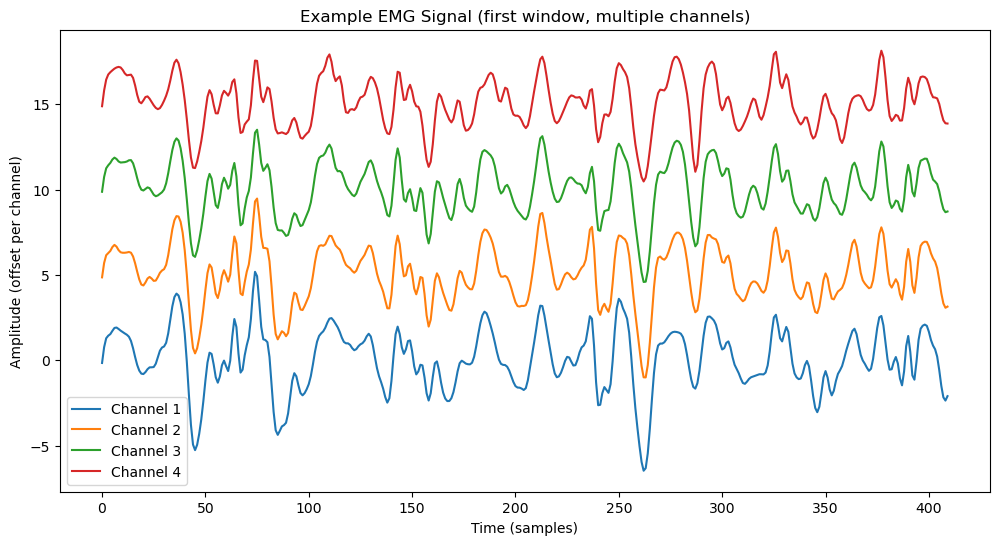

In [42]:
# vizuelizacija na raw EMG signals
import matplotlib.pyplot as plt

# one example(one window)
example = X_raw_train[0]  # (win_len, channels)

plt.figure(figsize=(12, 6))
for ch in range(min(4, example.shape[1])):  
    plt.plot(example[:, ch] + ch*5, label=f'Channel {ch+1}')

plt.title("Example EMG Signal (first window, multiple channels)")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (offset per channel)")
plt.legend()
plt.show()

In [43]:
from torch.utils.data import Dataset
import torch

class GRABMyoDataset(Dataset):
    def __init__(self, X_raw, X_feat, y):
        # (N, win_len, channels) -> (N, channels, win_len)
        self.X_raw = torch.tensor(X_raw, dtype=torch.float32).permute(0, 2, 1)
        self.X_feat = torch.tensor(X_feat, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_raw[idx], self.X_feat[idx], self.y[idx]

In [44]:
train_dataset = GRABMyoDataset(X_raw_train, X_feat_train, y_train)
test_dataset  = GRABMyoDataset(X_raw_test,  X_feat_test,  y_test)

In [45]:
from torch.utils.data import Dataset, DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64)

In [46]:
import torch
import torch.nn as nn

In [47]:
# balansiranje na samples
train_labels = y_train.astype(int)
samples_per_class = np.bincount(train_labels)

#class weights
class_weights = samples_per_class.sum() / samples_per_class
class_weights /= class_weights.mean()

sample_weights = class_weights[train_labels] #weights for every sample

from torch.utils.data import WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights,dtype=torch.float32),  
    num_samples=len(train_labels),                            
    replacement=True                                           
)

In [48]:
train_loader = DataLoader(train_dataset,
                          batch_size=128,
                          sampler=sampler,
                          num_workers=0,
                          pin_memory=True)
test_loader  = DataLoader(test_dataset,
                          batch_size=1024,
                          shuffle=False,
                          num_workers=0,
                          pin_memory=True)

In [49]:
import torch.nn as nn

class DepthwiseSeparableConv1D(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, dilation=1):
        super().__init__()
        self.depthwise = nn.Conv1d(
            in_ch, in_ch, kernel_size,
            stride=stride, padding=dilation,
            dilation=dilation, groups=in_ch, bias=False
        )
        self.pointwise = nn.Conv1d(in_ch, out_ch, 1, bias=False)
        self.bn = nn.BatchNorm1d(out_ch)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.bn(self.pointwise(self.depthwise(x))))


class LightweightCNN(nn.Module):
    def __init__(self, in_ch, num_classes, use_features=True, feat_dim=0):
        super().__init__()
        self.use_features = use_features

        self.conv = nn.Sequential(
            DepthwiseSeparableConv1D(in_ch, 64, 3, dilation=1),
            DepthwiseSeparableConv1D(64, 128, 3, dilation=2),
            DepthwiseSeparableConv1D(128, 256, 3, dilation=4),
        )
        self.gap = nn.AdaptiveAvgPool1d(1)

        in_dim = 256
        if use_features:
            in_dim += feat_dim

        self.fc = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )


    def forward(self, x_raw, x_feat=None):
        # x_raw: (B, channels, time)
        x = self.conv(x_raw)
        x = self.gap(x).squeeze(-1)  # (B, 256)

        if self.use_features and x_feat is not None:
            x = torch.cat([x, x_feat], dim=1)

        return self.fc(x)

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [51]:
model = LightweightCNN(
    in_ch=X_raw_train.shape[2],             # num channels
    num_classes=len(np.unique(y_train)),    # num gestures
    use_features=True,
    feat_dim=X_feat_train.shape[1]          # features po channel
).to(device)

In [52]:
train_labels = y_train.astype(int)
samples_per_class = np.bincount(train_labels, minlength=len(np.unique(y_train)))

# izbegnuvanje delenje so 0
if np.any(samples_per_class == 0):
    print("Warning: some classes have 0 samples in training set!")

samples_per_class = np.where(samples_per_class == 0, 1, samples_per_class)

class_weights = samples_per_class.sum() / samples_per_class
class_weights = class_weights / class_weights.mean()

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(weight=weight, reduction='none')

    def forward(self, logits, target):
        ce = self.ce(logits, target)                     
        with torch.no_grad():
            pt = torch.softmax(logits, dim=1).gather(1, target.view(-1,1)).squeeze(1).clamp_min(1e-8)
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean() if self.reduction == 'mean' else loss.sum()

class_w = torch.tensor(class_weights, dtype=torch.float32, device=device)
criterion = FocalLoss(gamma=2.0, weight=class_w)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [53]:
best_acc = 0.0
patience, bad_epochs = 6, 0
num_epochs = 50

@torch.no_grad()
def evaluate(loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_true = [], []
    for X_raw, X_feat, y in loader:
        X_raw, X_feat, y = X_raw.to(device, non_blocking=True), X_feat.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(X_raw, X_feat)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.numel()
        all_preds.append(pred.cpu())
        all_true.append(y.cpu())
    acc = correct / max(total, 1)
    return acc, torch.cat(all_true).numpy(), torch.cat(all_preds).numpy()

train_acc_history = []
test_acc_history = []

for epoch in range(1, num_epochs + 1):
    model.train()
    for X_raw, X_feat, y in train_loader:
        X_raw, X_feat, y = X_raw.to(device, non_blocking=True), X_feat.to(device, non_blocking=True), y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(X_raw, X_feat)
        loss = criterion(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        optimizer.step()

    train_acc, _, _ = evaluate(train_loader)
    test_acc,  y_true_win, y_pred_win = evaluate(test_loader)

    train_acc_history.append(train_acc)
    test_acc_history.append(test_acc)

    print(f"epoch {epoch:02d} | train_acc={train_acc:.3f} | test_acc={test_acc:.3f}")

    if test_acc > best_acc + 1e-4:
        best_acc, bad_epochs = test_acc, 0
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print("Early stopping.")
            break

# best model
model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

epoch 01 | train_acc=0.152 | test_acc=0.115
epoch 02 | train_acc=0.278 | test_acc=0.242
epoch 03 | train_acc=0.397 | test_acc=0.313
epoch 04 | train_acc=0.429 | test_acc=0.351
epoch 05 | train_acc=0.515 | test_acc=0.400
epoch 06 | train_acc=0.559 | test_acc=0.425
epoch 07 | train_acc=0.610 | test_acc=0.476
epoch 08 | train_acc=0.657 | test_acc=0.497
epoch 09 | train_acc=0.685 | test_acc=0.525
epoch 10 | train_acc=0.688 | test_acc=0.551
epoch 11 | train_acc=0.736 | test_acc=0.567
epoch 12 | train_acc=0.751 | test_acc=0.554
epoch 13 | train_acc=0.770 | test_acc=0.592
epoch 14 | train_acc=0.795 | test_acc=0.608
epoch 15 | train_acc=0.812 | test_acc=0.617
epoch 16 | train_acc=0.810 | test_acc=0.611
epoch 17 | train_acc=0.838 | test_acc=0.636
epoch 18 | train_acc=0.836 | test_acc=0.649
epoch 19 | train_acc=0.846 | test_acc=0.651
epoch 20 | train_acc=0.861 | test_acc=0.663
epoch 21 | train_acc=0.865 | test_acc=0.662
epoch 22 | train_acc=0.883 | test_acc=0.667
epoch 23 | train_acc=0.882 | tes

<All keys matched successfully>

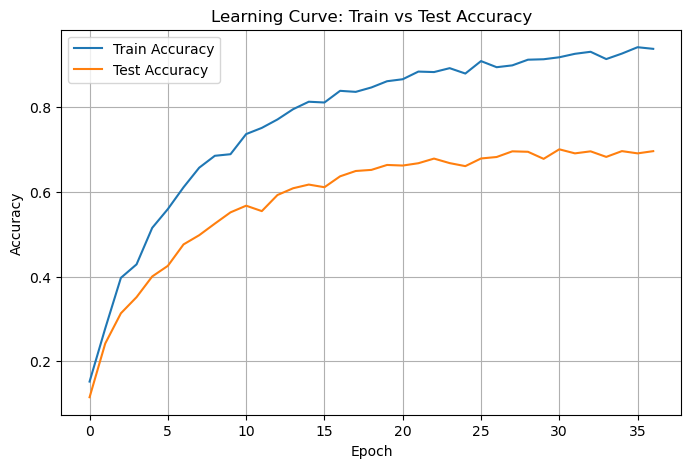

In [54]:
plt.figure(figsize=(8, 5))
plt.plot(train_acc_history, label="Train Accuracy")
plt.plot(test_acc_history, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Learning Curve: Train vs Test Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [55]:
@torch.no_grad()
def preds_and_targets(loader):
    model.eval()
    all_logits, all_t = [], []
    for X_raw, X_feat, y in loader:
        X_raw, X_feat = X_raw.to(device, non_blocking=True), X_feat.to(device, non_blocking=True)
        logits = model(X_raw, X_feat)
        all_logits.append(logits.cpu())
        all_t.append(y.cpu())
    logits = torch.cat(all_logits)
    y_true0 = torch.cat(all_t).numpy()
    y_pred0 = logits.argmax(1).numpy()
    return y_true0, y_pred0

y_true0, y_pred0 = preds_and_targets(test_loader)

print("Per-window report (raw + features):")
print(classification_report(y_true0+1, y_pred0+1, digits=3))

Per-window report (raw + features):
              precision    recall  f1-score   support

           1      0.735     0.719     0.727      1440
           2      0.526     0.734     0.613      1440
           3      0.583     0.692     0.633      1440
           4      0.638     0.554     0.593      1440
           5      0.857     0.822     0.839      1440
           6      0.914     0.786     0.845      1440
           7      0.574     0.432     0.493      1440
           8      0.861     0.861     0.861      1440

    accuracy                          0.700     11520
   macro avg      0.711     0.700     0.701     11520
weighted avg      0.711     0.700     0.701     11520



In [56]:
# after training
y_true0, y_pred0 = preds_and_targets(test_loader)

print("Per-window report (raw):")
print(classification_report(y_true0+1, y_pred0+1, digits=3))

# smoothed predictions -> korisno koga predviduvame po windows
from collections import deque
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

def smooth_preds(preds, K=7):
    out, q = [], deque(maxlen=K)
    for p in preds:
        q.append(p)
        out.append(np.bincount(list(q)).argmax())
    return np.array(out)

y_pred0_s = smooth_preds(y_pred0, K=11)

# mapiranje vo originalnite gesture id-s (1,2...)
y_true_ids = y_true0 + 1
y_pred_ids = y_pred0_s + 1

print("Per-window report (smoothed, gesture IDs):")
print(classification_report(y_true_ids, y_pred_ids, digits=3))
print(confusion_matrix(y_true_ids, y_pred_ids))

Per-window report (raw):
              precision    recall  f1-score   support

           1      0.735     0.719     0.727      1440
           2      0.526     0.734     0.613      1440
           3      0.583     0.692     0.633      1440
           4      0.638     0.554     0.593      1440
           5      0.857     0.822     0.839      1440
           6      0.914     0.786     0.845      1440
           7      0.574     0.432     0.493      1440
           8      0.861     0.861     0.861      1440

    accuracy                          0.700     11520
   macro avg      0.711     0.700     0.701     11520
weighted avg      0.711     0.700     0.701     11520

Per-window report (smoothed, gesture IDs):
              precision    recall  f1-score   support

           1      0.763     0.769     0.766      1440
           2      0.535     0.757     0.627      1440
           3      0.592     0.706     0.644      1440
           4      0.661     0.572     0.613      1440
          

<Figure size 800x800 with 0 Axes>

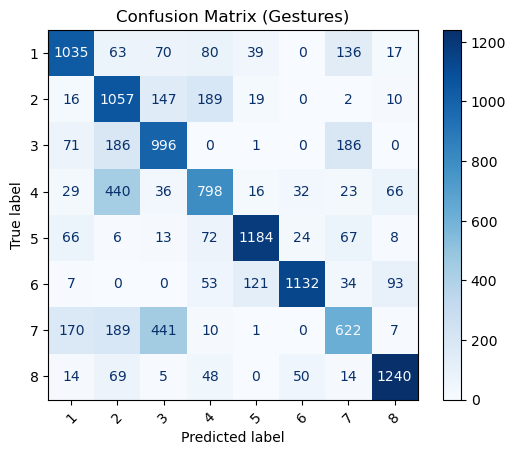

In [57]:
plt.figure(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(
    y_true0+1, y_pred0+1, 
    cmap="Blues", 
    xticks_rotation=45
)
plt.title("Confusion Matrix (Gestures)")
plt.show()